# Total Sales Forecasting for `Top 5 Manufacturers`

In [1]:
# dataframe opertations
import pandas as pd
import numpy as np
# plotting data - matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

#Ignore the warning, can comment this 
import warnings
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.options.display.float_format = '{:,}'.format
pd.options.display.float_format = "{:,.2f}".format

/Users/emi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Uploading data and indexing by time

In [2]:
# Import the data
data = pd.read_csv("data.csv")

In [3]:
#making a copy of the original data
df = data.copy()

In [4]:
#extracting unique manufacturer names
df['manufacturer'].value_counts()

MANUFACTURER 3         1583844
MANUFACTURER 2         1254761
OTHER MANUFACTURERS    1021396
MANUFACTURER 1          558699
MANUFACTURER 6          447466
MANUFACTURER 4          228649
MANUFACTURER 5          217437
Name: manufacturer, dtype: int64

In [5]:
#keeping rows necessary to filter top 5 manufacturers
df = df[['date', 'manufacturer', 'sales_(€)']]

In [6]:
df.head()

,date,manufacturer,sales_(€)
0,2020-10-18,MANUFACTURER 2,19.50
1,2020-10-18,MANUFACTURER 2,1.82
2,2020-10-18,MANUFACTURER 2,10.32
3,2020-10-18,MANUFACTURER 4,14.97
4,2020-10-18,MANUFACTURER 4,10.88


In [7]:
df['manufacturer'].value_counts()

MANUFACTURER 3         1583844
MANUFACTURER 2         1254761
OTHER MANUFACTURERS    1021396
MANUFACTURER 1          558699
MANUFACTURER 6          447466
MANUFACTURER 4          228649
MANUFACTURER 5          217437
Name: manufacturer, dtype: int64

In [8]:
#date to datetime object
df['date'] = pd.to_datetime(df['date'])

In [9]:
#grouping by date and adding total sales per manufacturer
manufacturers = df.groupby(['manufacturer'])['sales_(€)'].sum().to_frame().sort_values(by='sales_(€)', ascending=False)

In [10]:
manufacturers

,sales_(€)
manufacturer,
MANUFACTURER 3,"94,605,893.91"
MANUFACTURER 2,"61,757,760.51"
MANUFACTURER 6,"32,011,375.61"
MANUFACTURER 1,"26,503,102.14"
MANUFACTURER 4,"15,477,417.39"
OTHER MANUFACTURERS,"14,168,700.77"
MANUFACTURER 5,"7,009,680.12"


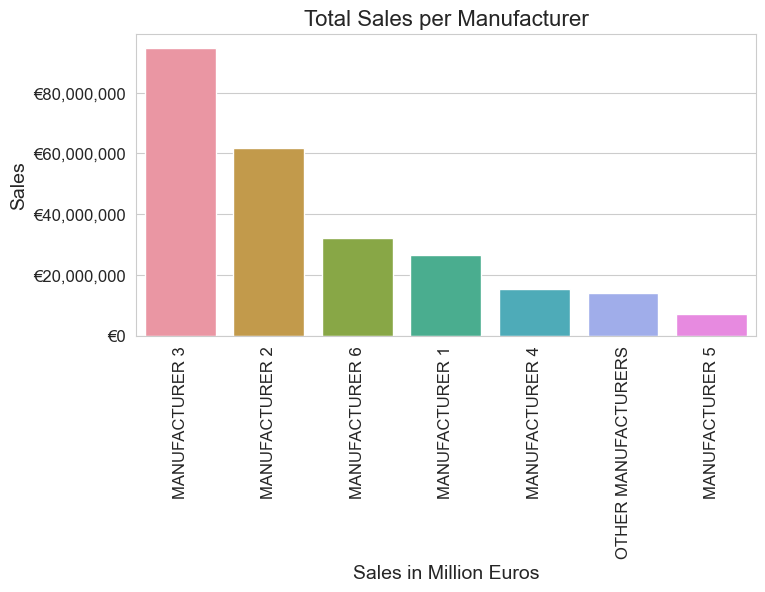

In [11]:
sns.set_style('whitegrid')

fig = plt.figure(figsize=(8, 4), dpi=100)  
ax = sns.barplot(x=manufacturers.index, y='sales_(€)', data=manufacturers)
# creating the bar plot
plt.xlabel("Sales in Million Euros")
plt.ylabel("Sales")


plt.title("Total Sales per Manufacturer", fontsize=16)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
plt.xticks(rotation=90)
plt.show()

In [12]:
#slicing the df based on manufacturers of interest
df = df.loc[((df.manufacturer == "MANUFACTURER 3") | (df.manufacturer == "MANUFACTURER 2")) | 
            ((df.manufacturer == 'MANUFACTURER 6') | (df.manufacturer == 'MANUFACTURER 1')) |
            ((df.manufacturer == "MANUFACTURER 4"))
           ]

#making sure that we are only handling the the top manufacturers
df['manufacturer'].unique()

array(['MANUFACTURER 2', 'MANUFACTURER 4', 'MANUFACTURER 3',
       'MANUFACTURER 1', 'MANUFACTURER 6'], dtype=object)

In [13]:
df.head()

,date,manufacturer,sales_(€)
0,2020-10-18,MANUFACTURER 2,19.50
1,2020-10-18,MANUFACTURER 2,1.82
2,2020-10-18,MANUFACTURER 2,10.32
3,2020-10-18,MANUFACTURER 4,14.97
4,2020-10-18,MANUFACTURER 4,10.88


In [14]:
#date to datetime object
df['date'] = pd.to_datetime(df['date'])

#grouping by week to get total weekly sales
df = df.groupby(['date'])['sales_(€)'].sum().to_frame()

#check output
df.head()

,sales_(€)
date,
2020-01-05,"1,564,866.31"
2020-01-12,"1,545,838.11"
2020-01-19,"1,548,646.27"
2020-01-26,"1,573,109.13"
2020-02-02,"1,707,863.88"


In [15]:
#shape should be 120x1
df.shape

(120, 1)

# Visualizing the Data

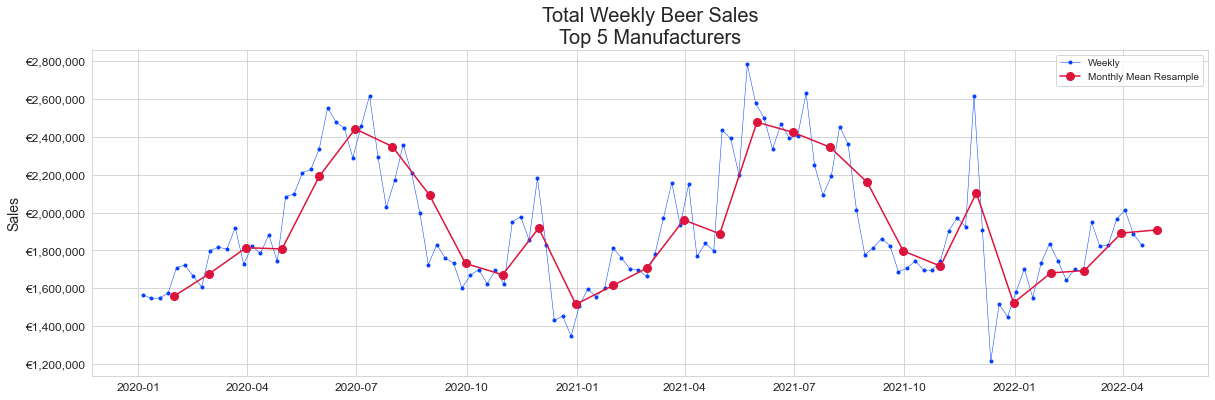

In [16]:
import seaborn as sns
sns.set_style("whitegrid")

import warnings
import matplotlib.pyplot as plt

y = df['sales_(€)']

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', 
        markersize=8, linestyle='-', 
        label='Monthly Mean Resample', 
        color='crimson')

plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_title("Total Weekly Beer Sales\nTop 5 Manufacturers", fontsize=20)
ax.set_ylabel('Sales')
ax.legend();

## Decomposing the Data

In [17]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

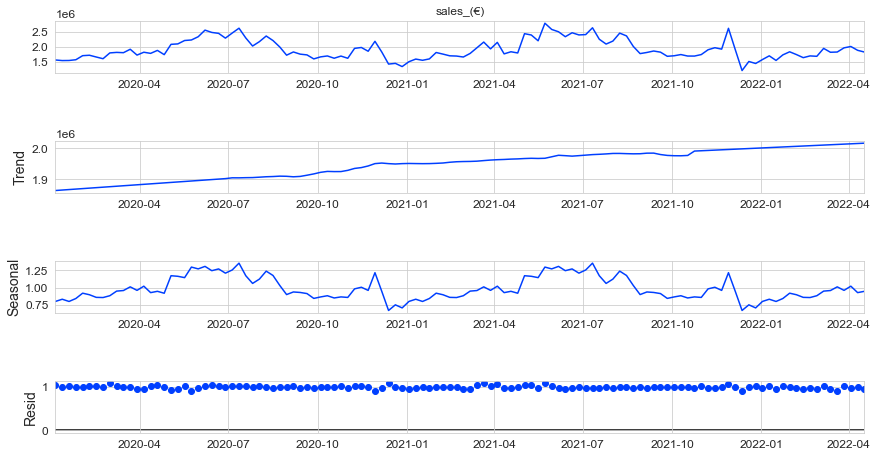

In [18]:
seasonal_decompose(y)

# Single HWES

In [19]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df.index.freq = "W"

# Set the value of Alpha and define m (Time Period)
m = 52
alpha = 1/(2*m)

#fitting the model
df['HWES1'] = SimpleExpSmoothing(df['sales_(€)']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

MAPE% on fitted values HW Single Exp Smoothing = 13.61%


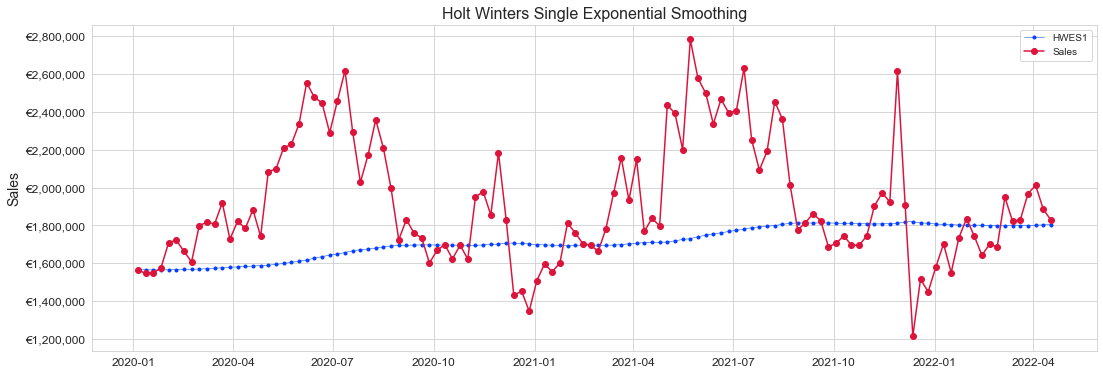

In [20]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES1'],marker='.', linestyle='-', linewidth=0.5, label='HWES1')
ax.plot(df['sales_(€)'],marker='o', markersize=6, linestyle='-', label='Sales', color='crimson')
ax.set_title(f"Holt Winters Single Exponential Smoothing", fontsize=16)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metric
mape_HWES1 = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES1'])*100, 2)

#printing evaluation metric
print(f'MAPE% on fitted values HW Single Exp Smoothing = {mape_HWES1}%')


## Observations
As expected, it didn’t fit quite well, and rightfully so, because if we remember, Single ES doesn’t work for data with Trends and Seasonality. 
Based on the decomposition of the data we have an upwards trend and we can also see a monthly seasonality

# Double HWES

In [21]:
df['HWES2_ADD'] = ExponentialSmoothing(df['sales_(€)'],trend='add').fit().fittedvalues

df['HWES2_MUL'] = ExponentialSmoothing(df['sales_(€)'],trend='mul').fit().fittedvalues

df[['sales_(€)','HWES2_ADD','HWES2_MUL']]

,sales_(€),HWES2_ADD,HWES2_MUL
date,,,
2020-01-05,"1,564,866.31","1,528,991.30","1,528,991.30"
2020-01-12,"1,545,838.11","1,583,891.25","1,585,805.61"
2020-01-19,"1,548,646.27","1,583,829.06","1,584,396.68"
2020-01-26,"1,573,109.13","1,585,349.64","1,585,665.40"
2020-02-02,"1,707,863.88","1,603,565.14","1,604,691.55"
...,...,...,...
2022-03-20,"1,828,599.04","1,839,279.01","1,849,250.91"
2022-03-27,"1,966,822.84","1,833,306.80","1,842,754.47"
2022-04-03,"2,012,007.57","1,935,429.12","1,948,702.08"


MAPE% for fitted values HWS2_ADD = 7.39%
MAPE% for fitted values HWS2_MUL = 7.5%


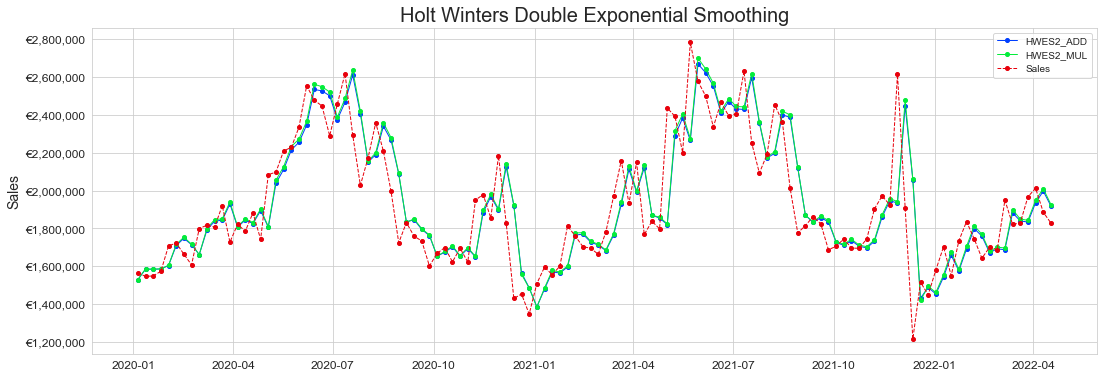

In [22]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES2_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_ADD')
ax.plot(df['HWES2_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales')
ax.set_title("Holt Winters Double Exponential Smoothing", fontsize=20)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metrics
mape_HWS2_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_ADD'])*100, 2)
mape_HWS2_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS2_ADD = {mape_HWS2_ADD}%')
print(f'MAPE% for fitted values HWS2_MUL = {mape_HWS2_MUL}%')

### Observations
Well, this looks a little better, but since we know there is Seasonality, we shall move into Triple ES and look at how it fits.

# Triple HWES

In [23]:
#Triple HWES helps us include a seasonal periods
    #our data has monthly seasonality so the number should be 12
df['HWES3_ADD'] = ExponentialSmoothing(df['sales_(€)'], trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

df['HWES3_MUL'] = ExponentialSmoothing(df['sales_(€)'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

df[['HWES3_ADD', 'HWES3_MUL', 'sales_(€)']]

,HWES3_ADD,HWES3_MUL,sales_(€)
date,,,
2020-01-05,"1,696,534.64","1,696,280.06","1,564,866.31"
2020-01-12,"1,495,092.50","1,515,990.88","1,545,838.11"
2020-01-19,"1,568,933.54","1,558,158.62","1,548,646.27"
2020-01-26,"1,634,878.14","1,614,337.69","1,573,109.13"
2020-02-02,"1,545,092.59","1,567,442.45","1,707,863.88"
...,...,...,...
2022-03-20,"1,919,595.91","1,892,990.89","1,828,599.04"
2022-03-27,"1,971,131.39","1,964,220.07","1,966,822.84"
2022-04-03,"1,983,084.66","1,965,084.72","2,012,007.57"


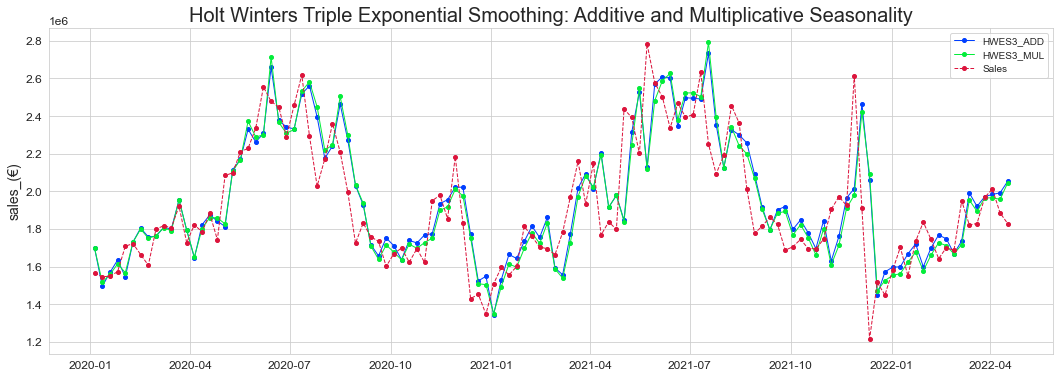

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES3_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_ADD')
ax.plot(df['HWES3_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales', color='crimson')
ax.set_title("Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality", fontsize=20)
ax.set_ylabel('sales_(€)')
ax.legend();

# Splitting into Train & Test Set
Why are we sticking with HW Triple Exponential Smoothing?
Because according to the diagnostic plots made in the beginning we know there is Seasonality and a Trend, therefore, this model is the best option for us 

In [25]:
forecast_data = data.copy() #making a copy of the original df

In [26]:
#slicing the df based on manufacturers of interest
forecast_data = forecast_data.loc[((forecast_data.manufacturer == "MANUFACTURER 3") | 
                                   (forecast_data.manufacturer == "MANUFACTURER 2")) | 
                                  ((forecast_data.manufacturer == 'MANUFACTURER 6') | 
                                   (forecast_data.manufacturer == 'MANUFACTURER 1')) |
                                  ((forecast_data.manufacturer == "MANUFACTURER 4"))
           ]

In [27]:
#making sure that we are only handling the NATIONAL segment
forecast_data['manufacturer'].unique()

array(['MANUFACTURER 2', 'MANUFACTURER 4', 'MANUFACTURER 3',
       'MANUFACTURER 1', 'MANUFACTURER 6'], dtype=object)

In [28]:
#converting to datetime index
forecast_data['date'] = pd.to_datetime(forecast_data['date'])

#groping by weekly total sales
forecast_data = forecast_data.groupby(['date'])['sales_(€)'].sum().to_frame()

In [29]:
forecast_data.head()

,sales_(€)
date,
2020-01-05,"1,564,866.31"
2020-01-12,"1,545,838.11"
2020-01-19,"1,548,646.27"
2020-01-26,"1,573,109.13"
2020-02-02,"1,707,863.88"


In [30]:
forecast_data.shape

(120, 1)

In [31]:
# Let’s try and forecast sequences, let us start by dividing the dataset into Train and Test Set.
# We have taken 96 data points as Train set and the last 24 data points as Test Set.

train = forecast_data[:105] 
test = forecast_data[105:]

In [32]:
print(train.index.min())
print(train.index.max())

2020-01-05 00:00:00
2022-01-02 00:00:00


In [33]:
print(test.index.min())
print(test.index.max())

2022-01-09 00:00:00
2022-04-17 00:00:00


In [34]:
print(test.shape)
print(test.shape)

(15, 1)
(15, 1)


# Fitting the Models to the train data & making forecasts

In [35]:
#creating an empty container to score model evaluation metrics
model_metrics = []

In [36]:
#defining a function to change parameters easily and do a trial and error procedure
def HW_model(trend, seasonal, seasonal_periods, damped, title):
    
    fitted_model = ExponentialSmoothing(train['sales_(€)'],
                                    trend=trend,
                                    seasonal=seasonal,
                                    seasonal_periods=seasonal_periods,
                                    use_boxcox=True,
                                    damped=damped, 
                                    initialization_method="estimated").fit()

    test_predictions = fitted_model.forecast(15) 
    title=title
    
    #plotting
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(train['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Train')
    ax.plot(test['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=4, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title(f'{title}\nTrain, Test and Predicted Values\n Holt-Winters ({trend}-{seasonal}-seasonal-damped={damped})', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend()
    plt.show()

    #zooming into test vs predicted
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(test['sales_(€)'], marker='o', markersize=5, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=5, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title('Zooming in', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend()
    plt.show()

    #saving metrics in variables
    mae = mean_absolute_error(test,test_predictions)
    mse = mean_squared_error(test,test_predictions)
    mape = round(mean_absolute_percentage_error(test,test_predictions)*100, 2)
    rmse = mean_squared_error(test,test_predictions, squared=False)
    
    #printing evaluation metrics        
    print(f'Mean Absolute Error = {mae}')
    print(f'Mean Squared Error = {mse}')
    print(f'MAPE% = {mape}%')
    print(f'RMSE = {rmse}')

    #saving metrics for later comparison
    model_metrics.append({
            "model" : f'HW ({trend}-{seasonal}-seasonal-damped={damped})',
            "MAE" : mae,
            "MSE": mse, 
            "MAPE": f'{mape}%', 
            "RMSE": f'{rmse}'
    })

## Holt-Winters (mul-mul-seasonal)

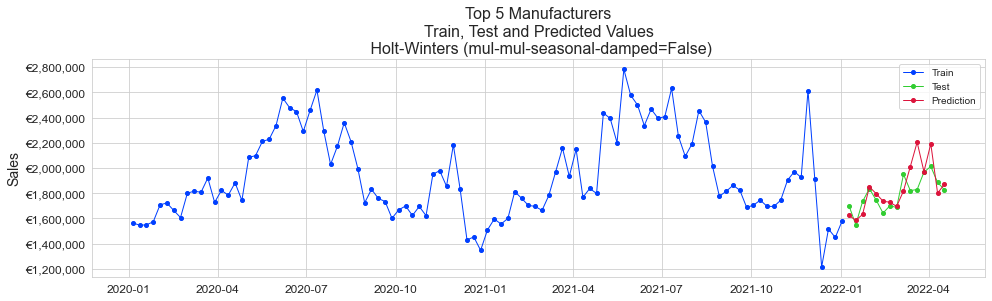

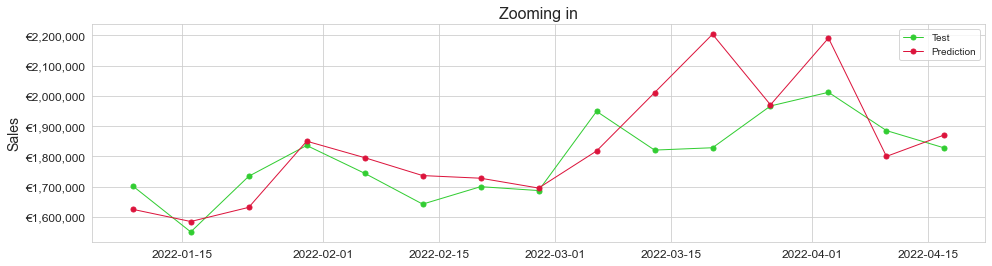

Mean Absolute Error = 94619.71165916714
Mean Squared Error = 17730326235.710083
MAPE% = 5.2%
RMSE = 133155.27115255364


In [37]:
HW_model('mul', 'mul', 52, False, "Top 5 Manufacturers")

## Holt-Winters (add-add-seasonal)

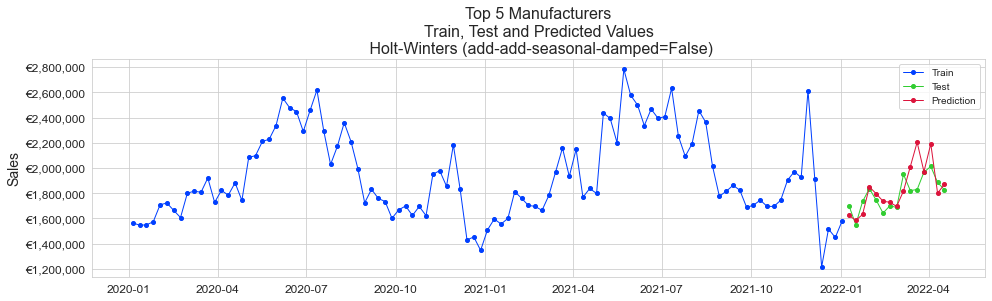

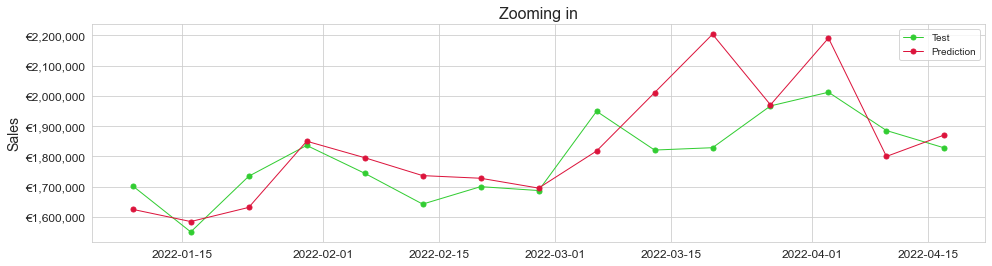

Mean Absolute Error = 94502.00462308244
Mean Squared Error = 17704143544.74621
MAPE% = 5.19%
RMSE = 133056.91843999023


In [38]:
HW_model('add', 'add', 52, False, "Top 5 Manufacturers")

## Holt-Winters (add-add-seasonal-damped)

In [39]:
help(HW_model)

Help on function HW_model in module __main__:

HW_model(trend, seasonal, seasonal_periods, damped, title)
    #defining a function to change parameters easily and do a trial and error procedure



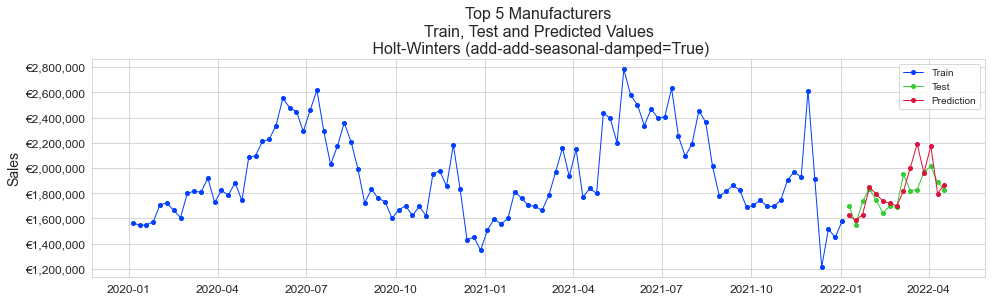

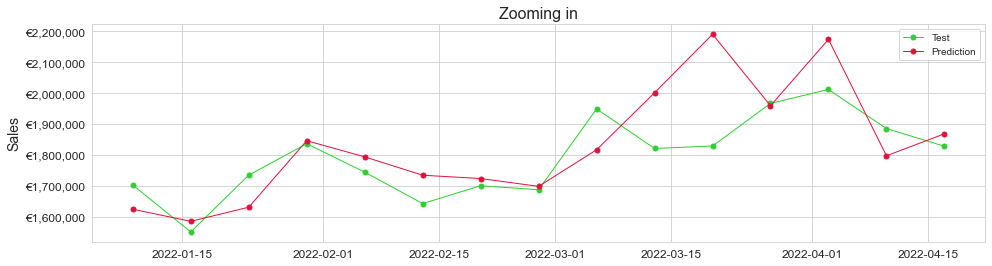

Mean Absolute Error = 91776.08339642668
Mean Squared Error = 16482895490.336658
MAPE% = 5.05%
RMSE = 128385.72930951734


In [40]:
HW_model('add', 'add', 52, True, 'Top 5 Manufacturers')

## Holt-Winters (add-mul-seasonal)

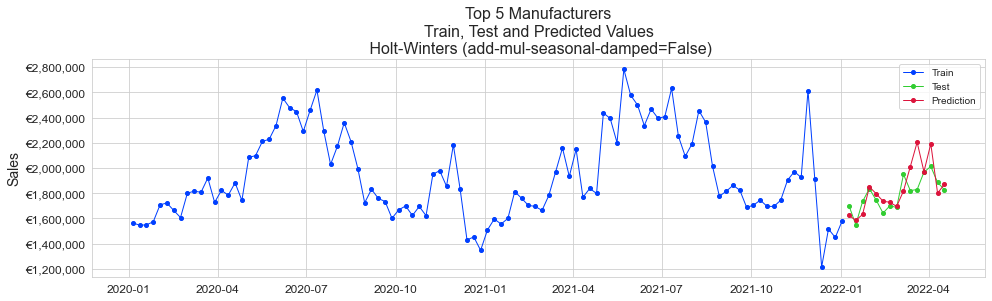

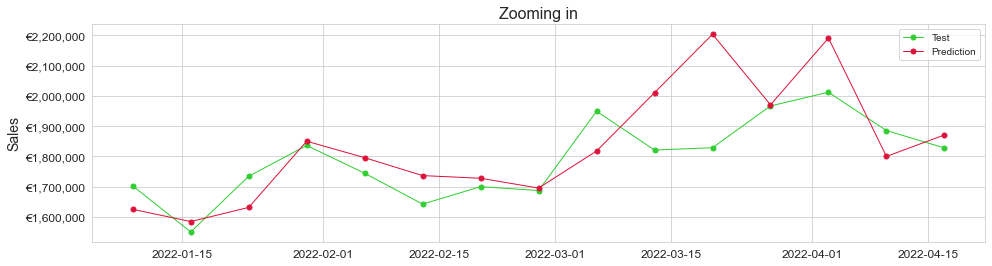

Mean Absolute Error = 94523.88977189275
Mean Squared Error = 17709099873.006645
MAPE% = 5.19%
RMSE = 133075.5419790077


In [41]:
HW_model('add', 'mul', 52, False, 'Top 5 Manufacturers')

## Holt-Winters (add-mul-seasonal-damped)

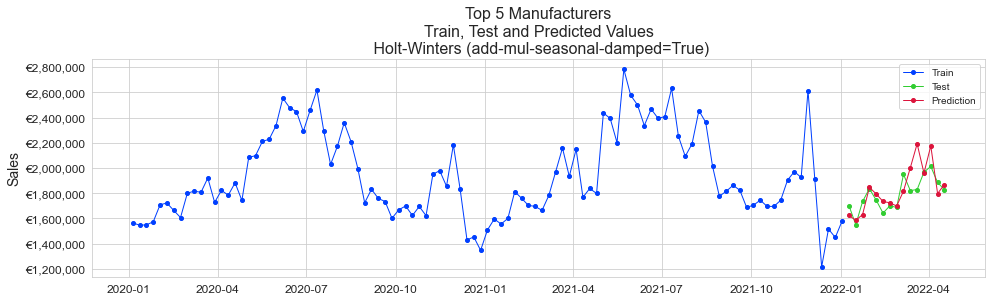

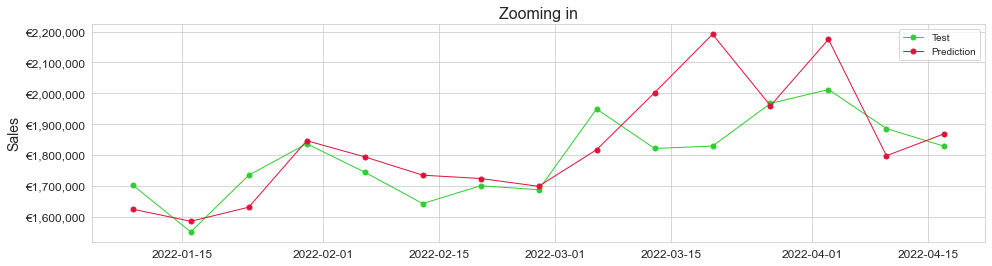

Mean Absolute Error = 91844.70092502
Mean Squared Error = 16500258969.046751
MAPE% = 5.05%
RMSE = 128453.33381834335


In [42]:
HW_model('add', 'mul', 52, True, "Top 5 Manufacturers")

# Model Comparison

In [43]:
model_metrics
model_metrics_df = pd.DataFrame(model_metrics, 
                                columns = ["model", 
                                           'MSE',
                                           'MAE', 
                                           "MAPE", 
                                           "RMSE"]).set_index("model").sort_values(by=["MAPE"], ascending = True)
model_metrics_df  

,MSE,MAE,MAPE,RMSE
model,,,,
HW (add-add-seasonal-damped=True),"16,482,895,490.34","91,776.08",5.05%,128385.72930951734
HW (add-mul-seasonal-damped=True),"16,500,258,969.05","91,844.70",5.05%,128453.33381834335
HW (add-add-seasonal-damped=False),"17,704,143,544.75","94,502.00",5.19%,133056.91843999023
HW (add-mul-seasonal-damped=False),"17,709,099,873.01","94,523.89",5.19%,133075.5419790077
HW (mul-mul-seasonal-damped=False),"17,730,326,235.71","94,619.71",5.2%,133155.27115255364


About the metrics:
* Remember that a 3.558%% MAPE implies the model is about 96.44% accurate in predicting the next 12 observations.

# Forecasting

In [48]:
#defining a function to make forecasts in any range of steps ahead
def final_HW_model(trend, seasonal, seasonal_periods, damped, steps_ahead, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=False, 
                            initialization_method="estimated").fit()
    
    simulations = fit.simulate(steps_ahead, repetitions=100, error="add")
    
    ax = forecast_data.plot(figsize=(18, 6), marker="o", markersize=4, lw=1)
    ax.set_title(f"Forecast and Simulation for {title}\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})\n Forecast for FY-2023", fontsize=18)
    ax.set_ylabel("Sales")
    ax.set_xlabel(" ")
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))

    fit.fittedvalues.plot(ax=ax, style="--", markersize=3, color="crimson", label='Fitted Values',  legend=True)
    simulations.plot(ax=ax, style="-", alpha=0.05, color="orange", legend=False)
    fit.forecast(steps_ahead).rename(f"Train, Test and Predicted Test\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})").plot(
    ax=ax, style="-", marker="o", markersize=4,  color="crimson", lw=1, legend=True, label='Predictions')
    
    return plt.show()

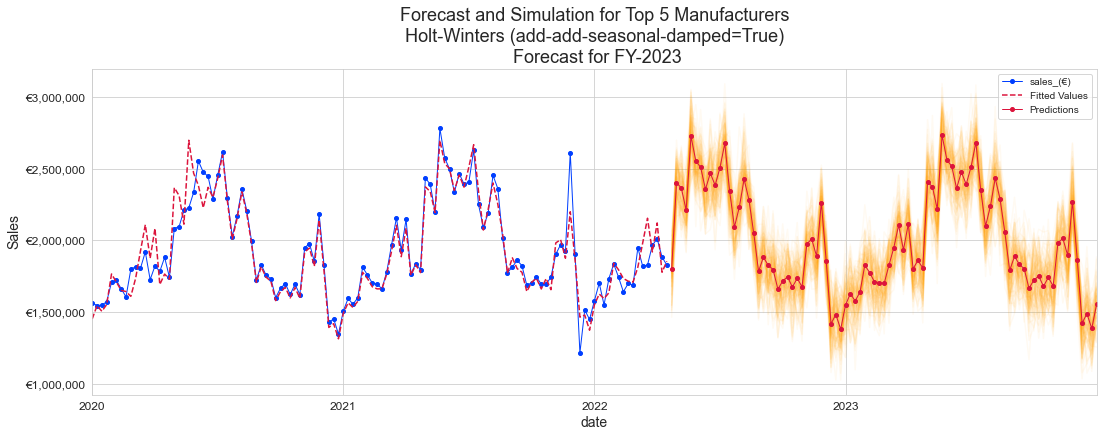

In [49]:
#why are we chooing 89 steps ahead?
    #because those the total steps ahead necessaty to do the forecast until the end of FY-2023
final_HW_model('add', 'add', 52, True, 89, 'Top 5 Manufacturers') 

In [50]:
#defining a function to get quarterly and yearly forecasts in euro value
def forecast_euro_value_until_2023(trend, seasonal, seasonal_periods, damped, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    title = title
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=False, 
                            initialization_method="estimated").fit()


    #making the forecast and putting values in inside a dataframe
    forecast = fit.forecast(89).to_frame().reset_index()

    #rename columns for more readability
    forecast.rename(columns={0: title, 'index': 'date'} ,inplace=True)

    #convert date column to datetime object
    forecast['date'] = pd.to_datetime(forecast['date'])

    #group by quarterly total sales
    return print(forecast.groupby(forecast['date'].dt.to_period('Q'))[title].sum().to_frame()), print(forecast.groupby(forecast['date'].dt.to_period('Y'))[title].sum().to_frame())

In [51]:
#calling the function to input the parameters of the best model and getting predictions in euro value
forecast_euro_value_until_2023('add', 'add', 52, True, "total_5_manufacturers_sales")

        total_5_manufacturers_sales
date                               
2022Q2                23,790,152.89
2022Q3                27,571,888.48
2022Q4                22,836,933.62
2023Q1                22,934,426.17
2023Q2                29,639,284.36
2023Q3                27,653,682.43
2023Q4                24,462,538.27
      total_5_manufacturers_sales
date                             
2022                74,198,974.98
2023               104,689,931.23


(None, None)